In [2]:
import numpy as np
import networkx as nx
from sklearn.cluster import SpectralClustering
from torch_geometric.datasets import GNNBenchmarkDataset
from torch_geometric.utils import to_dense_adj
from torch_geometric.utils import to_networkx, from_networkx

In [3]:
dataset = GNNBenchmarkDataset(root='tmp/gnn_benchmark', name='CSL')

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]
print(data)

Dataset: CSL(150):
Number of graphs: 150
Number of features: 0
Number of classes: 10
Data(edge_index=[2, 164], y=[1], num_nodes=41)


### Very basic generation of a graphon

This is much simpler than the method described in the paper, only here as a sorta placeholder/demo.

In [4]:
G = to_networkx(data)

In [5]:
# adjaency_matrix = to_dense_adj(data.edge_index).numpy().squeeze()
adjaency_matrix = nx.to_numpy_array(G)
adjaency_matrix

array([[0., 1., 1., ..., 0., 1., 1.],
       [1., 0., 1., ..., 0., 0., 1.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [1., 0., 0., ..., 1., 0., 1.],
       [1., 1., 0., ..., 1., 1., 0.]])

In [6]:
k = 10
clustering = SpectralClustering(n_clusters=k, affinity='precomputed').fit(adjaency_matrix)
labels = clustering.labels_

In [7]:
graphon = np.zeros((k, k))
for i in range(k):
    for j in range(k):
        nodes_i = np.where(labels == i)[0]
        nodes_j = np.where(labels == j)[0]
        # print(nodes_i, nodes_j)
        # raise ValueError('TODO: implement this')
        subgraph = G.subgraph(nodes_i.tolist() + nodes_j.tolist())
        graphon[i, j] = nx.density(subgraph)

In [16]:
import torch_geometric
from torch_geometric.data import Batch, Data
from torch_geometric.data.collate import collate
from torch_geometric.data.data import BaseData
from torch_geometric.data.dataset import Dataset, IndexType
from torch_geometric.data.separate import separate
from torch_geometric.io import fs

class GMixupDataset():
    r"""A wrapper class around a dataset that applies G-Mixup data augmentation to its base dataset.

    Args:
        base_dataset (Dataset): The dataset to apply G-Mixup to.
        TODO
    """

    def __init__(
        self,
        base_dataset: Dataset,
    ) -> None:
        self.base_dataset = base_dataset
        
        self.generate_graphons()
        
    def generate_graphons(self) -> None:
        self.graphs_by_class = [np.empty(0, dtype=int) for _ in range(self.base_dataset.num_classes)]
        
        # sort graphs by class
        for i, data in enumerate(self.base_dataset):
            label = data.y.item()
            self.graphs_by_class[label] = np.append(self.graphs_by_class[label], i)
            
        # for i in range(self.base_dataset.num_classes):
        #     print(self.graphs_by_class[i])
            
        # self.average_node_count = int(np.mean([data.num_nodes for data in self.base_dataset]))
        self.average_node_count = 20
        # print(self.average_node_count)
        
        self.graphons = np.zeros((self.base_dataset.num_classes, self.average_node_count, self.average_node_count))
        for i in range(self.base_dataset.num_classes):
            self.graphons[i] = self.generate_graphon(i)
        
        # print(self.graphons)
        return None
    
    def generate_graphon(self, class_idx: int) -> np.ndarray:
        r"""This is much simpler than the method described in the paper, only here as a sorta placeholder/demo.
        """
        # print(class_idx)
        # print(self.graphs_by_class[class_idx])
        # print()
        final_graphon = np.zeros((self.average_node_count, self.average_node_count))
        
        for graph_index in self.graphs_by_class[class_idx]:
            data = self.base_dataset[graph_index]
            G = to_networkx(data)
            adjaency_matrix = nx.to_numpy_array(G)
            
            clustering = SpectralClustering(n_clusters=self.average_node_count, affinity='precomputed').fit(adjaency_matrix)
            labels = clustering.labels_

            graphon = np.zeros((self.average_node_count, self.average_node_count))
            for i in range(self.average_node_count):
                for j in range(self.average_node_count):
                    nodes_i = np.where(labels == i)[0]
                    nodes_j = np.where(labels == j)[0]
                    subgraph = G.subgraph(nodes_i.tolist() + nodes_j.tolist())
                    graphon[i, j] = nx.density(subgraph)
                    
            final_graphon += graphon
            # print(graphon)
        
        final_graphon /= len(self.graphs_by_class[class_idx])
        return final_graphon

    # todo: check how IndexType works
    def generate_graphs(self, idx_1: int, idx_2: int, mixing_param: float) -> 'Dataset':
        r"""Takes in a batch of graph label pairs and a mixing parameter λ, and returns the new synthetic graph(s) generated using G-Mixup
        """
        graphon1 = self.graphons[idx_1]
        graphon2 = self.graphons[idx_2]
        mixed_graphon = mixing_param * graphon1 + (1 - mixing_param) * graphon2
        
        # print(mixed_graphon)
        
        K = 10 # number of nodes in output graph
        
        u_values = np.floor(1 / np.random.rand(K))
        adjacency_matrix = np.zeros((K, K))
        for i in range(K):
            for j in range(K):
                u_i = int(min(u_values[i], self.average_node_count - 1))
                u_j = int(min(u_values[j], self.average_node_count - 1))
                if np.random.rand() < mixed_graphon[u_i, u_j]:
                    adjacency_matrix[i, j] = 1
                    # adjacency_matrix[j, i] = 1
        print(adjacency_matrix)
                
        graph = nx.from_numpy_array(adjacency_matrix)
        
        return graph
    
    def __getattr__(self, name: str):
        if name in self.__dict__:
            return getattr(self, name)
        else:
            return getattr(self.base_dataset, name)

In [17]:
gmixup_dataset = GMixupDataset(dataset)

In [18]:
graph = gmixup_dataset.generate_graphs(0, 1, 0.5)
graph_pyg = from_networkx(graph)

[[0. 0. 1. 0. 1. 0. 0. 1. 0. 1.]
 [1. 0. 0. 1. 1. 1. 1. 1. 0. 1.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 1. 1. 0.]
 [1. 1. 0. 0. 1. 1. 0. 1. 0. 1.]
 [1. 0. 0. 0. 1. 1. 0. 1. 1. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1. 0. 1.]
 [1. 0. 0. 0. 1. 0. 0. 1. 1. 1.]
 [0. 1. 1. 1. 0. 0. 1. 0. 0. 0.]
 [1. 1. 1. 1. 0. 1. 0. 1. 0. 1.]]


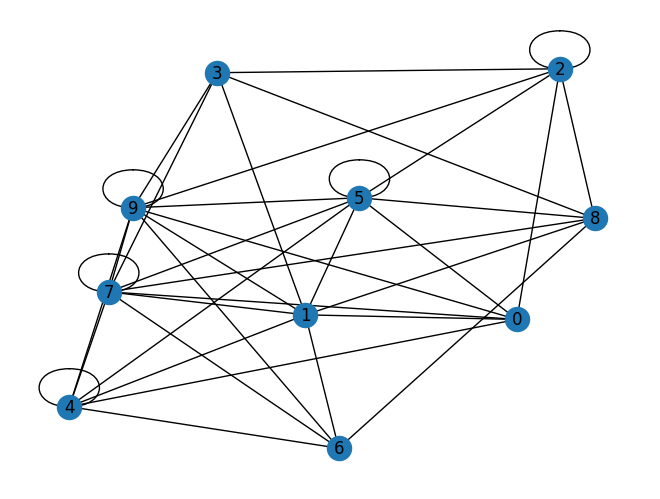

In [19]:
nx.draw(graph, with_labels=True)